##### Copyright 2018 The TensorFlow Constrained Optimization Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

> http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Overview

This notebook describes how to post-process the iterates of a constrained optimizer to construct a *stochastic classifier*, and to make predictions using the classifier. For illustration, we will consider a robust optimization task on a simulated dataset and solve the resulting constrained optimization problem using the proxy-Lagrangian optimizer. We will construct a stochastic classifier from the iterates of the optimizer, and show that it yields better performance compared to both the last iterate and the single best iterate identified by a heuristic.

Stochastic classifiers are particularly useful when we experience oscillations during training (as is the case with the simulated task we consider here). In such cases, even if no *particular* iterate of the optimizer does a good job of minimizing the objective while satisfying the constraints, the *sequence* of iterates, on average, usually will. This observation suggests constructing a stochastic classifier as follows:
during training, periodically snapshot the state of the model, and when given a new example to evaluate, sample a snapshot from this distribution, and apply it to the example to make a prediction. In this notebook, we will use the *shrinking* procedure of [[CoJiSr19]](https://arxiv.org/abs/1804.06500) to obtain a distribution over at most *m+1* snapshots, where *m* is the number of constraints, that will be at least as good as the larger uniform distribution over all snapshots. 

For applications where a stochastic classifier is not acceptable, we will also show how to pick a deterministic classifier from the iterates of the optimizer using the "best model" heuristic of [[CoJiSr19]](https://arxiv.org/abs/1804.06500) (though such a deterministic classifier may not always satisfy the specified constraints).

The example training problem that we consider is that of minimizing the *maximum of the false positive rate and false negative rate* of a classifier. By introducing a slack variable, this problem can be equivalently written as a rate-constrained optimization problem.

We start with the required imports. We will implement a two-layer neural network classifier using Keras and import the relevant modules here.

In [1]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from six.moves import xrange
import tensorflow.compat.v1 as tf

tf.disable_eager_execution()

# Tensorflow constrained optimization library
import tensorflow_constrained_optimization as tfco

Using TensorFlow backend.


## Generate Simulated Dataset

We generate a 1-dimensional dataset consisting of 1000 binary-labeled examples, where the positive examples are *sandwitched* between two groups of negative examples. We first label 5% of the examples as positive, and the remaining as negative. We then generate the features for the positive examples from a Gaussian centered at 0, and the features for the negative examples from a mixture of Gaussians centered at -1 and 1.

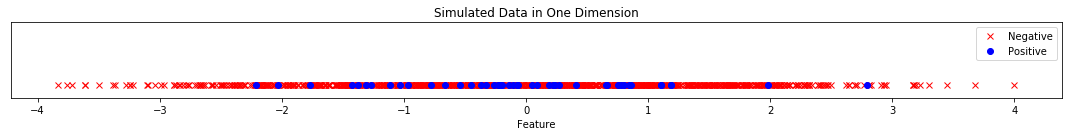

In [2]:
# Create a simulated 1-dimensional dataset consisting of 1000 binary-labeled examples,
# where the positive examples drawn from a normal distribution centered at 0 and the
# negative examples drawn from a mixture of normal distributions centered at -1 and +1. 

# Set random seed for reproducibility.
np.random.seed(10)
num_examples = 1000

# First generate the labels for the examples. Assign a label of 1 with probability 
# 0.05 and -1 with probability 0.95.
labels = np.random.rand(num_examples) > 0.95

# We will generate features for 1000 positive candidates, and 1000 negative candidates,
# and based on an example's label, we choose the feature from either the positive candidate
# or the negative candidate.

# Draw features for 1000 positive candidates from normal distribution centered at 0,
# with unit SD.
pos_examples = np.random.normal(0, 1, size=num_examples)

# Draw 1000 negative canidates from a mixture of normal distributions centeredat -1 and 1, 
# at -1 and 1, with unit SDs and with mixing proportion 0.5.
membership = np.random.rand(num_examples) > 0.5
distribution1 = np.random.normal(-1, 1, size=num_examples)
distribution2 = np.random.normal(1, 1, size=num_examples)
neg_examples = membership * distribution1 + (1 - membership) * distribution2

# Based on the label for each example, choose feature from either the positive 
# or negative candidates.
features = (labels > 0) * pos_examples + (labels <= 0) * neg_examples
# Reshape features to two-dimensions, so that the features array matches the shape
# of the input placeholder tensor.
features = features.reshape(num_examples, 1)  

# Plot data set.
ff, ax = plt.subplots(1, 1, figsize=(15, 2))
ax.plot(features[labels <= 0], [0.5] * sum(labels <= 0), "rx", label="Negative")
ax.plot(features[labels > 0], [0.5] * sum(labels > 0), "bo", label="Positive")
ax.set_xlabel("Feature")
ax.set_ylim([0.4, 1])
ax.set_yticks([])
ax.set_title("Simulated Data in One Dimension")
ax.legend()
ff.tight_layout()

Notice that a linear classifier would perform poorly on this data. We will learn a *two-layer neural network classifier* for this example.

## Set Up Classification Model

We are now ready to construct the classification model. To be able to construct a stochastic classifier from the training iterates, we will find it convenient to create a Python class that 
- maintains a Keras two-layer neural network model
- provides a snapshot of the current state of the model
- allows us to make stochastic predictions on new examples.

While we define this class for a two-layer neural network, one can easily define a similar wrapper class for any Keras model, provided the Keras layers used to construct the model have a `get_weights` function that returns the weights of the layers as a list, and a `set_weights` function that assigns values to the weights of the layer.

In [3]:
class StochasticModel():
    # Wrapper class around a 2-layer Keras model with snapshot 
    # and randomized predict functionalities.
    
    def __init__(self, input_dimension, num_hidden_nodes, dtype=tf.float32):
        # Creates a 2-layer NN with 'num_hidden_nodes' nodes in the hidden layer.
        self._input_dimension = input_dimension
        self._num_hidden_nodes = num_hidden_nodes
        self._dtype = dtype
        self._build_model()

    def _apply_layers(self, model_layers, input_tensor):
        # Helper function that applies a list of model_layers to an
        # input_tensor and returns the output_tensor.
        pred = self._input_tensor
        for layer in model_layers:
            pred = layer(pred)
        return pred
    
    def _build_model(self):
        # Creates tensors for a two-layer NN with 'num_hidden_nodes' nodes 
        # in the hidden layer. 
        # To write a stochastic model wrapper class for other Keras models, 
        # simply re-write this function with the associated Keras layers. 
        # We will need the layers used to have a get_weights function that 
        # returns the layer weights as a list of NumPy arrays and a set_weights 
        # function that sets layer weights from a list of NumPy arrays.
        
        # Input tensor.
        self._input_tensor = tf.keras.layers.Input(
            shape=(self._input_dimension,), 
            dtype=self._dtype)
        # Keras layers.
        self._layers = []
        self._layers.append(tf.keras.layers.Dense(self._num_hidden_nodes, 
                                                  activation="relu"))
        self._layers.append(tf.keras.layers.Dense(1))
        # Prediction tensor.
        self._predictions_tensor = self._apply_layers(self._layers, 
                                                      self._input_tensor)
        # Create Keras model.
        self._model = tf.keras.models.Model(inputs=self._input_tensor, 
                                            outputs=self._predictions_tensor)

    def _set_state(self, state):
        # Sets layer weights using provided model state.
        for ii in range(len(state)):
            self._layers[ii].set_weights(state[ii])
            
    def snapshot(self):
        # Returns current state: list of layer weights.
        return [layer.get_weights() for layer in self._layers]

    def predict(self, features, state=None):
        """Predicts on features using the specified state.
        
        Predicts on features using the specified state (if specified) 
        or the current state (if state is unspecified).
        
        Args:
            features: A NumPy array of shape (#num_examples, 1)
            states: A list of Keras layer weights.
            
        Returns:
            A NumPy array of shape (#num_examples,) containing {0, 1} predictions.
        """
        if state is None:  # Predict using current state.
            # Call the predict function provided by the Keras Model class.
            predictions = self._model.predict(features)
        else:  # Predict using provided state.
            # Record current state and restore it after making predictions.
            prev_state = self.snapshot()
            self._set_state(state)
            predictions = self._model.predict(features)
            self._set_state(prev_state)

        # Binarize real-valued predictions by thresholding at 0.
        predicted_labels = (predictions > 0).astype(np.float32)

        # Return predicted labels, reshaped to a one-dimensional array.  
        return predicted_labels.reshape(-1,)

    def randomized_predict(self, features, states, probabilities):
        """Predicts on features using a randomly chosen state.
        
        Chooses states[i] with probability probabilities[i] 
        and makes predictions on features using the chosen state.
        
        Args:
            features: A NumPy array of shape (#num_examples, 1)
            states: A list of Keras layer weights.
            probabilities: An array or list of probabilities with the same length as states.
            
        Returns:
            A NumPy array of shape (#num_examples,) containing {0, 1} predictions.
        """
        model_index = np.random.choice(np.arange(len(states)), p=probabilities)
        predicted_labels = self.predict(features, state=states[model_index])
        
        return predicted_labels
    
    def refresh(self):
        # Creates the model's graph afresh.
        # Useful when the computational graph has been reset.
        self._build_model()

    @property
    def input_tensor(self):
        # Returns a placeholder for the input features.
        return self._input_tensor

    @property
    def predictions_tensor(self):
        # Returns output predictions tensor.
        return self._predictions_tensor

Lets take a closer look at some of the functions defined in the above class.
- `snapshot`: Returns a snapshot of the current model state.
- `predict`: Given a feature matrix (and optionally a snapshot of the model state), makes predictions on the features using the specified state (if provided) or the current state of the model.
- `randomized_predict`: Given a feature matrix, a list of snapshots and a list of associated probabilities, makes predictions on the features using a randomly chosen snapshot.

Both `predict` and `randomized_predict` return an array of predicted labels (in {0, 1}). In addition to the above functions, the properties `input_tensor` and `predictions_tensor` in the above class provide a placeholder tensor for the input and output prediction tensor from the model, respectively. These tensors will be needed to set up the constrained optimization problem and perform training.

We use the above class to create a two layer neural network model with 5 hidden nodes.

In [4]:
# Reset existing TF graph.
tf.reset_default_graph() 

# Create a two-layer neural network with 5 hidden nodes.
model = StochasticModel(input_dimension=1, num_hidden_nodes=5, dtype=tf.float32)

# Get the input placeholder and prediction tensors from the model.
input_tensor = model.input_tensor
predictions_tensor = model.predictions_tensor

## Set Up Optimization Problem


Now that we have the output of the classification model, we can set up the constrained optimization problem. As noted before, we consider the task of minimizing the *maximum* of the *false positive rate* and the *false negative rate* of a classifier, i.e.
$$\min_{\theta}\, \max\big\{FPR(\theta),~ FNR(\theta)\big\},$$
where $\theta$ represents the set of the parameters of the model (weights and thresholds in each layer).

By introducing a slack variable $\xi$, this problem can be equivalently formulated as a constrained minimization problem:
$$\min_{\theta,\, \xi}\, \xi$$
$$s.t.~ FPR(\theta) \,\leq\, \xi,~ FNR(\theta) \,\leq\, \xi$$

We use the rate helpers provided by the TFCO library to set up this constrained problem. In particular, we use the `tfco.upper_bound` function to define an upper bounding `slack` on the false positive and false negative rates. This functions sets up the necessary constraints and proxy constraints for the problem and hides away all the details within the `slack` object. All we need to do now is to define a `RateMinimizationProblem` with the `slack` object as the objective, and leaving the constraints unspecified.

In [5]:
# Placeholder tensor for the labels.
labels_tensor = tf.placeholder(tf.float32, shape=(None,), name="labels")

# Define context using predictions and label tensors
context = tfco.rate_context(predictions_tensor, labels_tensor)

# Define rates and upper bound them with a slack.
fpr = tfco.false_positive_rate(context)
fnr = tfco.false_negative_rate(context)
slack = tfco.upper_bound([fpr, fnr])

# Set up rate minimization problem with the slack as the objective.
problem = tfco.RateMinimizationProblem(slack)

We can now move on to solving this constrained optimization problem. Since this problem uses proxy constraints (internally hidden by the `slack` object), we use the `ProxyLagrangianOptimizerV1`. We find the solver to exhibit oscillations for this problem, and to keep the oscillations under control, we use different optimizers for the gradient updates on the model parameters (layer weights and thresholds) and the gradient updates on the Lagrange multipliers (associated with the proxy constraints). We use the Adam optimizer for both updates. Having experimented with different learning rates for the two optimizers, we find it best to set the learning rate for updates on the model parameters to 0.001 and the learning rate for updates on the Lagrange multipliers to 0.01. 

In [6]:
# Set up optimizer.
model_learning_rate = 0.001
constraint_learning_rate = 0.01
# Optimizer for updates on the model parameters and the Lagrange multipliers.
model_optimizer = tf.train.AdamOptimizer(learning_rate=model_learning_rate)
constraint_optimizer = tf.train.AdamOptimizer(learning_rate=constraint_learning_rate)
# Set up proxy-Lagrangian optimizer.
optimizer = tfco.ProxyLagrangianOptimizerV1(
    optimizer=model_optimizer, constraint_optimizer=constraint_optimizer)
train_op = optimizer.minimize(problem)

Before proceeding to train our model, we will write a couple of functions to measure its performance.

In [7]:
def false_positive_rate(true_labels, predicted_labels):
    # Returns false positive rate for given true and predicted labels.
    # Calculate fraction of negative examples that were classified as positive.
    neg_predictions = predicted_labels[true_labels <= 0] 
    return np.mean(neg_predictions > 0)

def false_negative_rate(true_labels, predicted_labels):
    # Returns false negative rate for given true and predicted labels.
    # Calculate fraction of positive examples that were classified as negative.
    pos_predictions = predicted_labels[true_labels > 0] 
    return np.mean(pos_predictions <= 0)

## Model Training

We are now ready to train the model. First, create a new TF session and initialize the local and global variables. Since we will train a Keras model, we will have to register the created session with the Keras backend.

In [8]:
# Create TF session.
session = tf.Session()
# Tell Keras to use the created TF session.
tf.keras.backend.set_session(session)

# Set random seeds.
np.random.seed(100)
tf.set_random_seed(1000)

# Initialize global variables.
# (to make sure that the results are reproducible, 
# initialize the variables after setting the random seeds).
session.run(tf.global_variables_initializer())

We will perform 10000 *full* gradient updates. Once in 100 iterations, we will record a snapshot of the model state, the objective (the value of the slack) and the violations in each constraint. A snapshot of the model state can be obtained by using the function `snapshot` in the `model` object. The current objective and the magnitude of constraint violations can be obtained by fetching the values of the `problem.objective` and `problem.constraints` tensors respectively. For the present problem, `problem.objective` provides us with the value of the slack $\xi$, and `problem.constraints` provides us with a list containing the false positive violations $FPR(\theta) - \xi$ and false negative violations $FNR(\theta) - \xi$. It is worth noting that the constraint values appear in `problem.constraints` in no particular order.

Note that we will need to feed the features and labels to the `input_tensor` and `labels_tensor` placeholders everytime we perform gradient updates (i.e. execute `train_op`) and fetch the objective and constraint value.

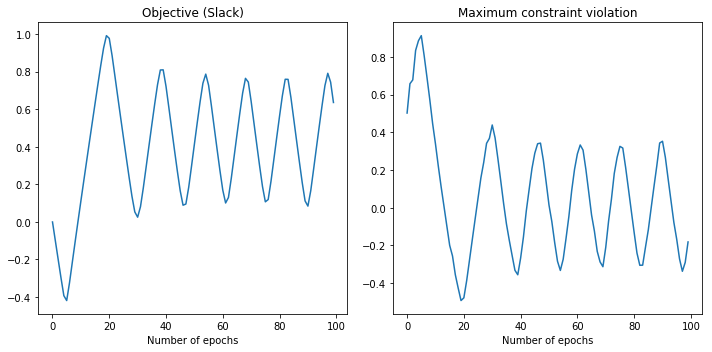

In [9]:
# Training iterations.
loops = 10000
skip_iterations = 100

objectives = []
constraints = []
states = []

for ii in xrange(loops):
    # Perform gradient updates, feeding in the features and labels.
    session.run(train_op, feed_dict={input_tensor: features, labels_tensor: labels})

    # Once in 50 iterations, snapshot the model state, 
    # and record the objective and constraint violations.
    if ii % skip_iterations == 0:
        # Snapshot of current model state.
        state = model.snapshot()
        states.append(state)
        # Current objective and constraint violations.
        objective, constraint = session.run((problem.objective(), problem.constraints()),
                                            feed_dict={input_tensor: features, labels_tensor: labels})
        objectives.append(objective)
        constraints.append(constraint)

# Close TF session.
session.close()
    
# Plot objective and (the max) constraint violation across iterations.
ff, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(len(objectives)), objectives)
ax[0].set_title("Objective (Slack)")
ax[0].set_xlabel("Number of epochs")

ax[1].plot(range(len(constraints)), np.max(constraints, axis=1))
ax[1].set_title("Maximum constraint violation")
ax[1].set_xlabel("Number of epochs")

ff.tight_layout()

## Last Iterate

Having completed training, we now need to construct a classifier from the model iterates. Given the oscillatory nature of the objective and constraint values, we recommend constructing a stochastic classifier from the iterates. As a baseline, let us first look at the performance of last iterate.

In [10]:
# We first re-create the computational graph for the model.
# This is useful when the earlier graph has been reset, 
# and also avoids carrying over any stale information from previous runs.
model.refresh()

# Since we have closed the earlier TF session used for training, 
# we first create a new TF session and initialize the variables.
eval_session = tf.Session()
tf.keras.backend.set_session(eval_session)
eval_session.run(tf.global_variables_initializer())

# Predict labels using last recorded snapshot and evaluate its performance.
predicted_labels = model.predict(features, state=states[-1])    
fpr = false_positive_rate(labels, predicted_labels)
fnr = false_negative_rate(labels, predicted_labels)
print("Last iterate model:")
print("False positive rate = %.3f" % fpr)
print("False negative rate = %.3f" % fnr)
print("max{FPR, FNR} = %.3f" % max(fpr, fnr))

Last iterate model:
False positive rate = 0.421
False negative rate = 0.455
max{FPR, FNR} = 0.455


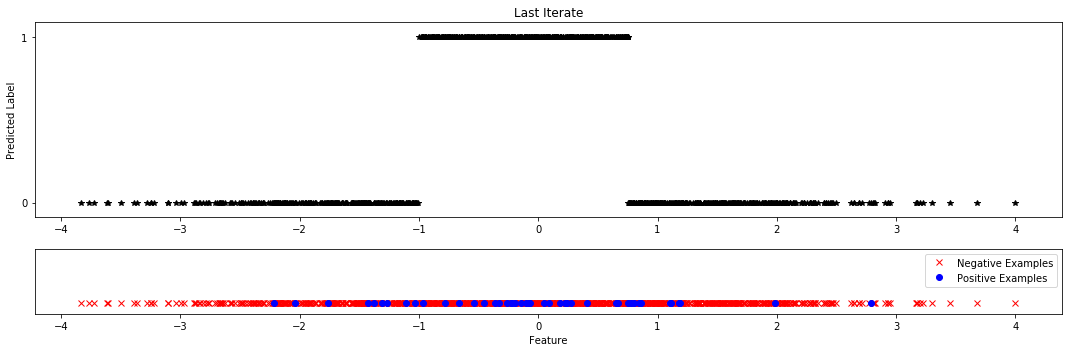

In [11]:
# Plot predictions from last iterate model, along with the dataset.
ff = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# Plot predictions.
ax = plt.subplot(gs[0])
ax.plot(features, predicted_labels, "k*")
ax.set_ylabel("Predicted Label")
ax.set_ylim([-0.09, 1.09])
ax.set_yticks([0, 1])
ax.set_title("Last Iterate")

# Plot dataset.
ax = plt.subplot(gs[1])
ax.plot(features[labels <= 0],[0] * sum(labels <= 0), "rx", 
        label="Negative Examples")
ax.plot(features[labels > 0], [0] * sum(labels > 0), "bo", 
        label="Positive Examples")
ax.legend()
ax.set_xlabel("Feature")
ax.set_ylim([-0.1, 0.5])
ax.set_yticks([])

ff.tight_layout()

The predictions made by the last iterate model seem intuitive&mdash;the model makes positive predictions in a interval in the feature space, where the postive examples are densely distributed, and makes negative predictions everywhere else. Let us see if we can beat the performance of the last iterate by constructing a stochastic classifier from the recorded snapshots.

## Stochastic Classifier

We apply the *shrinking* procedure of [CoJiSr19] implemented in the `tfco.find_best_candidate_distribution` function to obtain a distribution over the recorded snapshots. This function takes an array of objective values of shape (n,), where n is the number of snapshots, and an array of constraint violations of shape (n, m), where m is the number of constraints (for the present problem, m=2). The function returns an array of probabilties of shape (n,), where the i-th entry is the probability associated with the i-th snapshot.

In [98]:
probabilities = tfco.find_best_candidate_distribution(
    np.array(objectives), np.array(constraints))

print("Number of non-zero probabilities = %d" % sum(probabilities > 0))

Number of non-zero probabilities = 3


As noted earlier the shrinking procedure outputs a distribution over at most *m+1* snapshots. For the present problem, the final stochastic classifier is a distribution over 3 snapshots. 

To make a prediction using the obtained probabilties, we can use the `model.randomized_predict` function. Given a feature matrix, a list of snapshots, and an array of associated probabilities, 
this function choses a snapshot at random and makes a prediction on the features. We use this function to make randomized predictions on the training dataset, and evaluate the average predicted labels, the average false positive rates and the average false negative rates over 1000 repeated predictions.

In [99]:
avg_fpr = 0 
avg_fnr = 0
avg_predicted_labels = np.zeros(features.shape[0])

# Set random seed so that the results are reproducible.
np.random.seed(10000)

# Repeat for 1000 trials.
num_trials = 1000
for i in range(num_trials):
    predicted_labels = model.randomized_predict(features, states, probabilities)
    avg_predicted_labels += predicted_labels
    avg_fpr += false_positive_rate(labels, predicted_labels)
    avg_fnr += false_negative_rate(labels, predicted_labels)
    
avg_fpr /= num_trials
avg_fnr /= num_trials
avg_predicted_labels /= num_trials
  
# Print average FPR and FNR.
print("Stochastic classifier:")
print("False positive rate = %.3f" % avg_fpr)
print("False negative rate = %.3f" % avg_fnr)
print("max{FPR, FNR} = %.3f" % max(avg_fpr, avg_fnr))

Stochastic classifier:
False positive rate = 0.412
False negative rate = 0.414
max{FPR, FNR} = 0.414


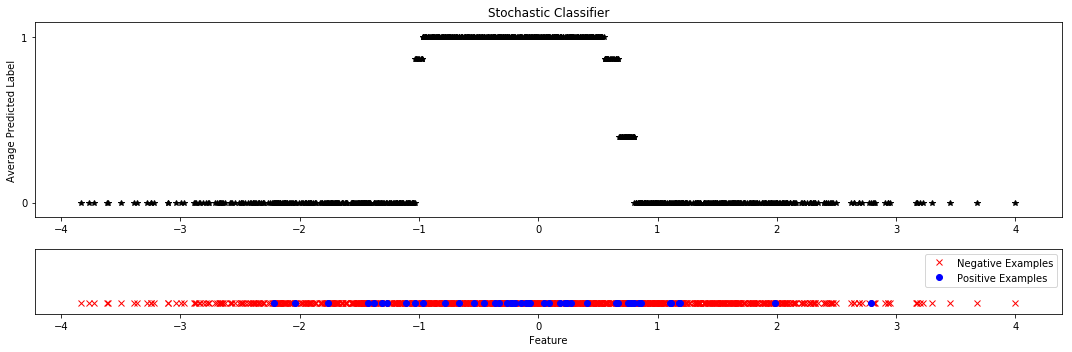

In [100]:
# Plot average predicted labels from stochastic classifier, along with the dataset.
ff = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# Plot predictions.
ax = plt.subplot(gs[0])
ax.plot(features, avg_predicted_labels, "k*")
ax.set_ylabel("Average Predicted Label")
ax.set_ylim([-0.09, 1.09])
ax.set_yticks([0, 1])
ax.set_title("Stochastic Classifier")

# Plot dataset.
ax = plt.subplot(gs[1])
ax.plot(features[labels <= 0],[0] * sum(labels <= 0), "rx", 
        label="Negative Examples")
ax.plot(features[labels > 0], [0] * sum(labels > 0), "bo", 
        label="Positive Examples")
ax.legend()
ax.set_xlabel("Feature")
ax.set_ylim([-0.1, 0.5])
ax.set_yticks([])

ff.tight_layout()

Notice that there are regions in the feature space, where the average predicted label is between 0 and 1. The stochastic model is most likely to predict a positive label close to the feature value 0, and is less likely to predict a positive label as we move away from 0. The use of a stochastic classifier yields a lower max{FPR, FNR} than the deterministic model from the last iterate. 

## Best Deterministic Classifier

For applications where a stochastic classifier is not acceptable, one can use the "best model" *heuristic* provided in [CoJiSr19] to pick a deterministic classifier from the optimizer iterates. This heuristic is implemented in the function `tfco.find_best_candidate_index`, which takes an array of objective values and an array of constraint violations as inputs, and outputs the index of the heuristically identified best iterate.

In [13]:
best_iterate = tfco.find_best_candidate_index(
    np.array(objectives), np.array(constraints))

print("Index of best iterate = %d" % best_iterate)

Index of best iterate = 34


In [14]:
predicted_labels = model.predict(features, state=states[best_iterate])    
fpr = false_positive_rate(labels, predicted_labels)
fnr = false_negative_rate(labels, predicted_labels)
print("Last iterate model:")
print("False positive rate = %.3f" % fpr)
print("False negative rate = %.3f" % fnr)
print("max{FPR, FNR} = %.3f" % max(fpr, fnr))

Last iterate model:
False positive rate = 0.429
False negative rate = 0.409
max{FPR, FNR} = 0.429


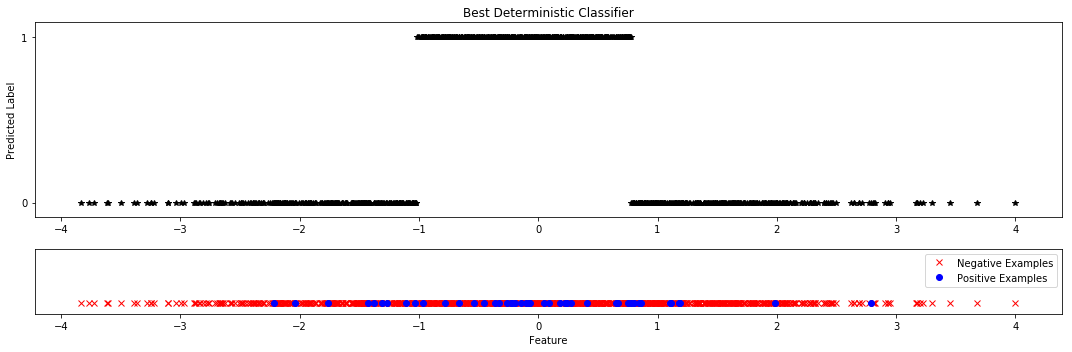

In [17]:
# Plot predictions from the best iterate model, along with the dataset.
ff = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# Plot predictions.
ax = plt.subplot(gs[0])
ax.plot(features, predicted_labels, "k*")
ax.set_ylabel("Predicted Label")
ax.set_ylim([-0.09, 1.09])
ax.set_yticks([0, 1])
ax.set_title("Best Deterministic Classifier")

# Plot dataset.
ax = plt.subplot(gs[1])
ax.plot(features[labels <= 0],[0] * sum(labels <= 0), "rx", 
        label="Negative Examples")
ax.plot(features[labels > 0], [0] * sum(labels > 0), "bo", 
        label="Positive Examples")
ax.legend()
ax.set_xlabel("Feature")
ax.set_ylim([-0.1, 0.5])
ax.set_yticks([])

ff.tight_layout()

The identified deterministic classifier yields a lower max{FPR, FNR} compared to the last iterate, but is slightly worse of compared to the stochastic classifier. Indeed a deterministic classifier identified using the above heuristic may be good enough for most practical applications. However, one may not always be able to find a feasible deterministic classifier from the iterates of the constrained optimizer (especially when there a large number of constraints in the training problem). Even for such difficult constrained optimization problems, the shrinking procedure is guaranteed to provide us with a stochastic classifier that is feasible on the training problem.

In [101]:
# Close the eval session.
eval_session.close()